Ece Pidik

260620324

ECSE 415 

Assignment 4

#  1. Data Acquisition

The image I used belongs to the cast of the famous British drama series, Sherlock. From left to right the image displays Mycroft Holmes (performed by Mark Gatiss), John Watson (performed by Martin Freeman), and Sherlock Holmes (performed by Benedict Cumberbatch). The image size is (187x400)pixels.

The individiual photos of the cast members in the photo was selected from online sources. I tried selecting images that where the full frontal view of the individuals were clearly displayed. The training set images include a large range of emotions, light, and angles. This was done on purpose, to make sure that the training data gave more precise results when doing face detection and identification.

All the training set images were cropped to fit the face of the individual as good as possible. They were then resized to (90x60) pixels. This size approximately matches the size of the window that the faces in the group photo would fit into.

In [1]:
import cv2
import sys
import numpy as np
from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

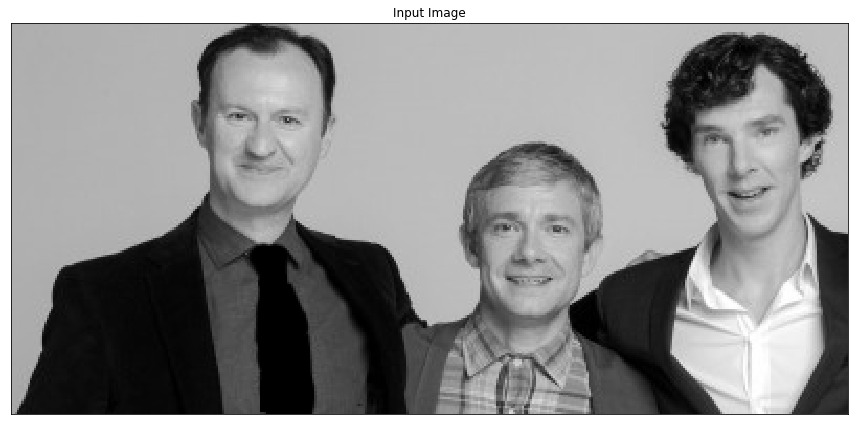

In [2]:
img_input = cv2.imread('sherlock_cast_2.png')
img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img_input, cv2.COLOR_GRAY2RGB))
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.show()

# 2. Eigenvector Representation

In [3]:
# Creates the data matrix by flattining all the training set images that belong to 1 face
# Creates a (10x5400) matrix 10: number of images, 5400: flattened out image vector
def createDataMatrix(images):
    h, w= images[0].shape
    data = np.zeros((len(images), h * w), dtype=np.float32)
    for i in range(0, len(images)):
        image = images[i].flatten()
        data[i,:] = image
     
    return data

In [4]:
def read_and_process():
# I seperated the data into 3 individual data matrices (one per each face) 
# -> (e.g. data_s: sherlock, data_w: watson, etc.)

    images_s = []
    images_w = []
    images_m = []
    
    for i in range(1, 11):
        img = cv2.imread('training_data/sherlock_cropped_resized'+str(i)+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images_s.append(img)      
    data_s = createDataMatrix(images_s)
    
    for i in range(1, 11):
        img = cv2.imread('training_data/watson_cropped_resized'+str(i)+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images_w.append(img)
    data_w = createDataMatrix(images_w)
        
    for i in range(1, 11):
        img = cv2.imread('training_data/mycroft_cropped_resized'+str(i)+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        images_m.append(img)     
    data_m = createDataMatrix(images_m)
    
    return data_s, data_w, data_m

In [5]:
def get_explained_variance(data):
    
#     Yay for built in functions
    pca = PCA(n_components=None)
    pca.fit_transform(data)
    
    eigenvectors = pca.components_
    eigenvalues = pca.explained_variance_
    
#     Return the normalized eigenvalues to graph them correctly
    eigenvalues_normalized = eigenvalues/max(eigenvalues) 
    
    return eigenvalues_normalized, eigenvectors

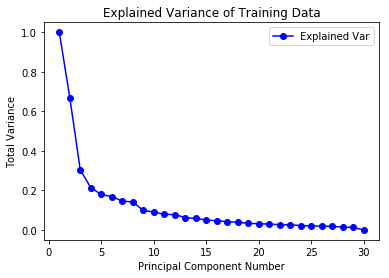

In [6]:
data_s, data_w, data_m = read_and_process()

# concatenate individual data sets (1 per face, each contain 10 image data)
# we are going to use this data_cluster throughout the next sections as well
data_cluster = np.concatenate((data_s, data_w, data_m), axis=0)

# Plot the eigenvalues to see the principal components required
eigenvalues_normalized_all, eigenvectors_all = get_explained_variance(data_cluster)

plt.plot(range(1, len(eigenvalues_normalized_all)+1), eigenvalues_normalized_all, '-o', color="blue", label="Explained Var")
plt.title("Explained Variance of Training Data")
plt.ylabel("Total Variance")
plt.xlabel("Principal Component Number")
plt.legend()
plt.show() 

As can be seen from the graph above, we don't need all the eigenvectors. In fact after most of the information is stored in the 4 best eigenvectors. After that adding more eigenvectors do not affect the variance significantly. In this circumstance adding all the eigenvectors would result to overfitting, and in general it's smarter to avoid this.

In [7]:
def find_closest_face(data):
    correct_identification_counter = 0
    for v in data:
        min_dist = 99999999
        most_similar_face = ""
        for v_compared in data:
            if (v != v_compared): #So that we don't compare the image to itself
                dist = distance.euclidean(v[0], v_compared[0])
                if (dist < min_dist):
                    min_dist = dist
                    most_similar_face = v_compared[1]
        if(str(v[1]) == most_similar_face):
            correct_identification_counter = correct_identification_counter + 1
    return correct_identification_counter

In [8]:
# This section checks each training image to see if it's in the right cluster using eigenVectors 
og_data = []

for i in range(0, 10):
    og_data.append([data_cluster[i], "Sherlock"])
for i in range(0, 10):
    og_data.append([data_cluster[i+10], "Watson"])
for i in range(0, 10):
    og_data.append([data_cluster[i+20], "Mycroft"])

correct_identification_counter = find_closest_face(np.array(og_data))
print("Using the original images " + str(correct_identification_counter) + " out of " + str(len(og_data)) + " training set images matched the right person")

Using the original images 30 out of 30 training set images matched the right person


/Users/ece.pidik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  import sys


In [9]:
# This section checks each training image to see if it's in the right cluster using eigenvectors 
mean_s, eigenvectors_s = cv2.PCACompute(data_s, mean=None, maxComponents=10)
mean_w, eigenvectors_w = cv2.PCACompute(data_w, mean=None, maxComponents=10)
mean_m, eigenvectors_m = cv2.PCACompute(data_m, mean=None, maxComponents=10)

vector_data = []

for vector_s in eigenvectors_s:
    vector_data.append([vector_s, "Sherlock"])
for vector_w in eigenvectors_w:
    vector_data.append([vector_w, "Watson"])
for vector_m in eigenvectors_m:
    vector_data.append([vector_m, "Mycroft"])

correct_identification_counter = find_closest_face(np.array(vector_data))
print("Using the eigenvectors " + str(correct_identification_counter) + " out of " + str(len(vector_data)) + " training set images matched the right person")

Using the eigenvectors 30 out of 30 training set images matched the right person


/Users/ece.pidik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  import sys


Both using eigenvectors and original pixel space classified all the images in our training set correctly. Although we can't see a difference from our training set, using eigenvectors is a better idea as eigenvectors are better at identifying the main features of the image. For example if there are 2 images with 2 different faces have very similar background, and the background takes a big portion, those images might get clustered to the same neighborhood using the original pixel space. In that circumstance using the eigenvectors method will work better.

# Face Detection & Identification

In [10]:
# Create the mean face by averaging all the images in the cluster
mean_face = np.zeros((1,90*60))
for i in data_cluster:
    mean_face = np.add(mean_face,i)
    
mean_face = np.divide(mean_face, float(30)).flatten()
 
# Create a normalize training data by substraction the mean face from each image in the training data
data_cluster_normalized = data_cluster
for i in range(len(data_cluster)):
    data_cluster_normalized[i] = data_cluster[i]-mean_face

# Find the covariance matrix of the normalized training data
cov_matrix = np.cov(data_cluster)
cov_matrix = np.divide(cov_matrix, 8.0)

# Get the eigenvalues and the eigenvectors from the covariance data
eigenvalues_cov, eigenvectors_cov = np.linalg.eig(cov_matrix)

# Match the eigenvalues to the corresponding eigenvectors to be able to sort the eigenvalues
eigen_pairs = [(eigenvalues_cov[i], eigenvectors_cov[:,i]) for i in range(len(eigenvalues_cov))]
eigen_pairs.sort(reverse=True)
eigvalues_sorted  = [eigen_pairs[index][0] for index in range(len(eigenvalues_cov))]
eigvectors_sorted = [eigen_pairs[index][1] for index in range(len(eigenvalues_cov))]

# Get the best 10 eigenvectors -. I put an arbitrary number
best_eigenvectors = np.array(eigvectors_sorted[0:10]).transpose()

#  Create the eigenspace
eigenspace = np.dot(data_cluster.transpose(),best_eigenvectors)
eigenspace = eigenspace.transpose()

# Create the weights array that corresponds to the weight of each training image
weights = np.array([np.dot(eigenspace,i) for i in data_cluster_normalized])

In [11]:
def detect_face(window_image, mean_face, weights, eigenvectors, eigenspace):
    
    window_image = np.array(window_image, dtype='float64').flatten()
    
    # Normalize window by substracting the mean face
    window_image_normalized = np.subtract(window_image,mean_face)
    
    # Projecting the normalized window onto the eigenspace
    projected_window = np.dot(eigenspace, window_image_normalized)
    
    diff  = weights - projected_window
    norms = np.linalg.norm(diff, axis=1)
    
    return min(norms)

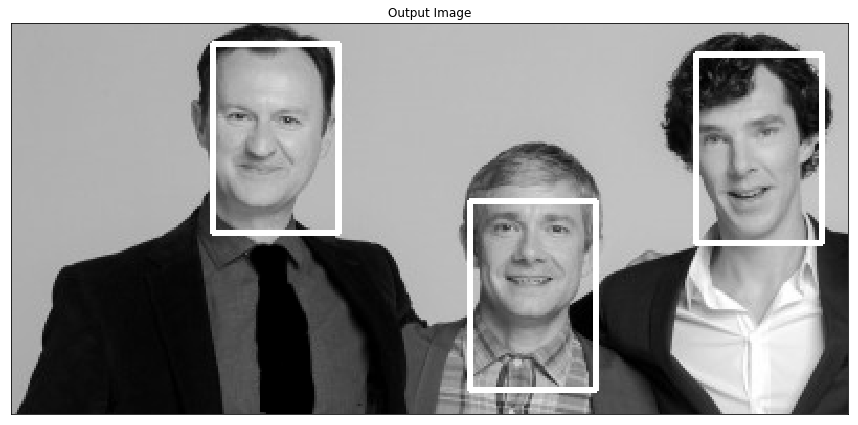

In [12]:
img = cv2.imread('sherlock_cast_2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
output = img.copy()

(window_height, window_width) = (90, 60)

imgs_face = []
#  (10, 18), (15,18), (18,18), (36, 36, 11800000) -> these step sizes give decent detection results too
# This function iterates over the image using windows
def sliding_window(img, windowSize):
    for y in range(0, img.shape[0], 5):
        for x in range(0, img.shape[1], 3):
            yield (x, y, img[y:y + windowSize[1], x:x + windowSize[0]])

for (x, y, window) in sliding_window(img, windowSize=(window_width, window_height)):
    if window.shape[0] != window_height or window.shape[1] != window_width:
        continue
        
    # find the similarity between the current window and our eigenspace for faces
    face_possibility_val = detect_face(window, mean_face, weights, best_eigenvectors, eigenspace)

    #  There is only a high treshold which also identifies false positives
#     if (face_possibility_val < 8770000):
#         cv2.rectangle(output, (x, y), (x + window_width, y + window_height), (0,0,0), 1)
    
    # This if statement got rid of the false positives by setting a lower treshold
    if (face_possibility_val < 8770000 and face_possibility_val> 8400000):
        imgs_face.append(window)
        cv2.rectangle(output, (x, y), (x + window_width, y + window_height), (255,255,0), 2)
    
# # display images
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_GRAY2RGB))
plt.title("Output Image"), plt.xticks([]), plt.yticks([])
plt.show()
        

In [13]:
def identify_person(window_image, mean_face, weights, eigenspace):
    
    window_image = np.array(window_image, dtype='float64').flatten()
    
    # Normalize window by substracting the mean face
    window_image_normalized = np.subtract(window_image,mean_face)
    
    # Projecting the normalized window onto the eigenspace
    projected_window = np.dot(eigenspace, window_image_normalized)
    
    diff  = weights - projected_window
    norms = np.linalg.norm(diff, axis=1)
    
    counter = 0
    
# #  # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

## Commented out code is the method that maps the window to your eigenspace (uncomment it to use this code instead)
## and find the nearest neighbour from your data. It's k times which gets the kth nearest neighbour in the data
## this is required to match Mycroft's and Sherlock's images to the right neighbour.
## Instead of implementing this metg

#         counter = np.argmin(norms) #1st neighbour returns right result for Watson only 
#         norms[counter] = 100000000
#         counter = np.argmin(norms)
#         norms[counter] = 100000000
#         counter = np.argmin(norms) #3rd neighbour returns right result for Sherlock  
#         norms[counter] = 100000000
#         counter = np.argmin(norms) #4th neighbour returns right result for Mycroft 
#         if(counter >= 0 and counter <10):
#             return "Sherlock"
#         if(counter >= 10 and counter <20): 
#             return "Watson"
#         if(counter >= 20 and counter <30):
#             return "Mycroft"

# #  # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

#   Instead of the method above, get the 10 min norms and check which training image set they belong to 
#   Increment the counter that corresponds to the face the training set image belongs to
#   Get the max counter to see if the image matched Sherlock, Watson, or Mycroft most of the times
    mcyroft_counter = sherlock_counter = watson_counter = 0
    for i in range(0, 10):
        counter = np.argmin(norms)
        norms[counter] = 100000000 # Set the current smallest norm to a high number to get the next smallest norm in the next it.
        if(counter >= 0 and counter <10):
            sherlock_counter = sherlock_counter + 1
        if(counter >= 10 and counter <20):
            watson_counter = watson_counter + 1 
        if(counter >= 20 and counter <30):
            mcyroft_counter = mcyroft_counter + 1

    if(sherlock_counter >= mcyroft_counter and sherlock_counter >= watson_counter):
        return "Sherlock"
    elif (mcyroft_counter >= sherlock_counter and mcyroft_counter >= watson_counter):
        return "Mycroft"
    else:
        return "Watson"
    
# #  # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

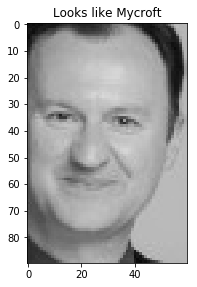

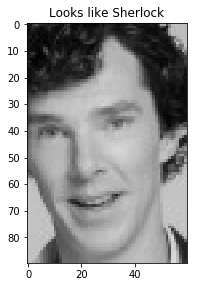

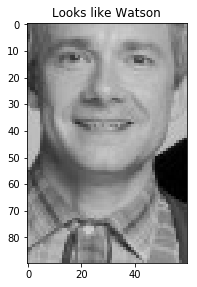

In [14]:
for i in range(3):
    person = identify_person(imgs_face[i], mean_face, weights, eigenspace)
    
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1+i)
    plt.title("Looks like " +person)
    plt.imshow(cv2.cvtColor(imgs_face[i], cv2.COLOR_GRAY2RGB))


# 3.1 Image Detection

In my implementation I got 11 false positives (black windows). However if I set a lower treshold we can get rid of all the false positives (white windows). My implementation, however is not very reliable as, the number of false positives and false negatives depend heavilty on the step size (x, y) = (5, 3), treshold value, and the training set. Also the windows are not perfectly centered around the actual faces

# 3.2 Image Identification

Using the method where we map the window to your eigenspace and find the nearest neighbour from your data:

1. Watson gets identified on the 1st neighbour (correct identification)
2. Sherlock gets identified on the 3rd neighbour
3. Mycroft gets identified on the 4th neighbour

Since this method didn't work well for identifying the faces in my photo, I decided to implement another method that worked a lot method. In this method instead of identifying the image using just the min norm, I iterated over 10 of the min norms and checked which training dataset neigborhood was matched the most times. This gave the correct result for each image.



# Viola-Jones Comparison

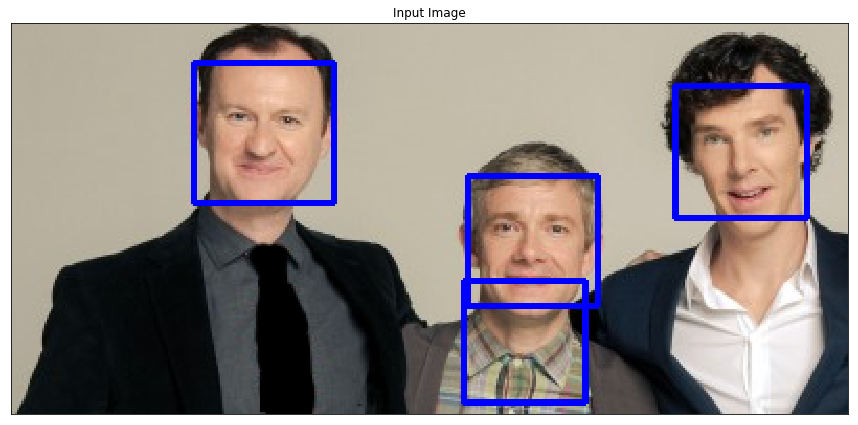

In [15]:
import os
# Viola-Jones face detector
img_v = cv2.imread('sherlock_cast_2.png')
img_v_gray = cv2.cvtColor(img_v, cv2.COLOR_BGR2GRAY)

data_path = cv2.data.haarcascades
face_cascade = cv2.CascadeClassifier( os.path.join(data_path, 'haarcascade_frontalface_default.xml'))

# detect faces
# detectMultiScape(image, scaleFactor, minNeighbors)
# scaleFactor - parameter specifying how much the image size is reduced
#  at each image scale
# minNeighbors - parameter specifying how many neighbors each candidate
#  rectangle should have to retain
faces = face_cascade.detectMultiScale(img_v_gray, 1.1,2)
for (x,y,w,h) in faces:
    cv2.rectangle(img_v, (x,y), (x+w, y+h), (255,0,0), 2)
    roi_gray = img_v_gray[y:y+h, x:x+w]
    roi_color = img_v[y:y+h, x:x+w]
    
# display images
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img_v, cv2.COLOR_BGR2RGB))
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.show()

From Viola-Jones implementation we only got 1 false positive, and all the windows were centered around the actual images. This shows that this method works way better than my face detection implementation.  PCA will not perform well when variance of the features in the image set does not encompass the actual differences between the images and the most distinguishing features are contained in the smaller eigenvectors. Viola-Jones doesn't do dimensionality decrease so it wouldn't affect this method as much.